In [51]:
import torch
import os
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.torch_version
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import transforms
from torchmetrics import Accuracy, Precision, Recall

In [52]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [53]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
main_path = '/kaggle/input/isic-2024-challenge' if iskaggle else 'data/isic-2024-challenge'

In [54]:
train_metadata_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv' if iskaggle else 'data/isic-2024-challenge/train-metadata.csv'
test_metadata_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv' if iskaggle else 'data/isic-2024-challenge/test-metadata.csv'

train_metadata_df = pd.read_csv(train_metadata_path)
test_metadata_df = pd.read_csv(test_metadata_path)

print(len(train_metadata_df))

C:\Users\abdfa\AppData\Local\Temp\ipykernel_42852\3275392473.py:4: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata_df = pd.read_csv(train_metadata_path)


401059


In [55]:
import sklearn.model_selection as train_test_split

train_size = 0.8
# Splitting the train dataset into positive and negative samples and saving them in separate dataframes
postive_samples = train_metadata_df[train_metadata_df['target'] == 1]
negative_samples = train_metadata_df[train_metadata_df['target'] == 0]
print(f"Positive samples: {postive_samples.shape}")
print(f"Negative samples: {negative_samples.shape}")

Positive samples: (393, 55)
Negative samples: (400666, 55)


In [56]:

# Splitting each type of samples into train and validation sets
train_positive_samples, val_positive_samples = train_test_split.train_test_split(postive_samples,test_size=1-train_size)
train_negative_samples, val_negative_samples = train_test_split.train_test_split(negative_samples,test_size=1-train_size)
print(f"Train positive samples: {train_positive_samples.shape}")
print(f"Train negative samples: {train_negative_samples.shape}")
print(f"Val positive samples: {val_positive_samples.shape}")
print(f"Val negative samples: {val_negative_samples.shape}")


Train positive samples: (314, 55)
Train negative samples: (320532, 55)
Val positive samples: (79, 55)
Val negative samples: (80134, 55)


In [57]:

# Concatenating the positive and negative samples to get the train and validation sets
train_metadata_df = pd.concat([train_positive_samples, train_negative_samples])
val_metadata_df = pd.concat([val_positive_samples, val_negative_samples])
print(f"Train samples: {train_metadata_df.shape}")
print(f"Val samples: {val_metadata_df.shape}")
print(f"Test samples: {test_metadata_df.shape}")


Train samples: (320846, 55)
Val samples: (80213, 55)
Test samples: (3, 44)


In [58]:
import h5py
from io import BytesIO

train_hdf5_path = '/kaggle/input/isic-2024-challenge/train-image.hdf5' if iskaggle else 'data/isic-2024-challenge/train-image.hdf5'
test_hdf5_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5' if iskaggle else 'data/isic-2024-challenge/test-image.hdf5'

In [59]:
train_hdf5_file = h5py.File(train_hdf5_path,'r')
test_hdf5_file = h5py.File(test_hdf5_path,'r')

In [60]:
class CustomDataset(Dataset):
    def __init__(self, hdf5_file, metadata_df,target=None, transform=None):
        self.hdf5_file = hdf5_file
        self.metadata_df = metadata_df
        self.image_ids = metadata_df['isic_id']
        self.labels = target
        self.transform = transform

        self.mean_of_color_channels = None  # Initialize as None
        self.std_of_color_channels = None   # Initialize as None
        # self._calculate_stats()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids.iloc[idx]
        image = Image.open(BytesIO(self.hdf5_file[image_id][()]))

        # Calculate mean and standard deviation if not already done
        # if self.mean_of_color_channels is None or self.std_of_color_channels is None:
        #     self._calculate_stats()

        # Apply transformation with calculated statistics
        if self.transform:
            image = self.transform(image)

        if self.labels is not None:
            label = self.labels.iloc[idx]
            return image, label
        else:
            return image
   

In [61]:
# HyperParameters
dim = 50
batch_size = 64

In [62]:
train_transform = transforms.Compose([ 
    transforms.Resize((dim, dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize(mean_of_color_channels, std_of_color_channels),
])

train_transform_modified = transforms.Compose([ 
    transforms.Resize((dim, dim)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize(mean_of_color_channels, std_of_color_channels),
])

test_transform = transforms.Compose([
    transforms.Resize((dim, dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize(mean_of_color_channels, std_of_color_channels),
])

In [63]:
train_dataset = CustomDataset(train_hdf5_file,train_metadata_df,target=train_metadata_df['target'],transform=train_transform)
val_dataset = CustomDataset(train_hdf5_file,val_metadata_df,target=val_metadata_df['target'],transform=train_transform)
test_dataset = CustomDataset(test_hdf5_file,test_metadata_df,transform=test_transform)

In [64]:
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [73]:
class Model(nn.Module):
    def __init__(self,num_classes,device,dim = 32,num_epochs = 20,learning_rate = 0.001,early_stopping = False):
        super().__init__()
        self.num_of_classes = num_classes
        self.device = device
        self.dim = dim
        # Debugging
        self.DEBUG = True
        # Hyperparameters
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.early_stopping = early_stopping
        # History while Training
        self.model_loss_history = []
        self.model_train_acc_history = []
        self.model_val_acc_history = []
        self.model_val_precision_history = []
        self.model_val_recall_history = []
        self.model_lr_history = []

        # Model Attributes
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = None
        self.accuracy = Accuracy(task= 'multiclass', num_classes=self.num_of_classes, average='macro').to(self.device)
        self.precision = Precision(task= 'multiclass', num_classes=self.num_of_classes, average='macro').to(self.device)
        self.recall = Recall(task= 'multiclass', num_classes=self.num_of_classes, average='macro').to(self.device)
        # Model Architecture
        self.feature_extract = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        self.classifier = nn.Sequential(            
            nn.Linear(20000, self.num_of_classes),
        )
        
    def forward(self, x):
        x = self.feature_extract(x)
        x = self.classifier(x)
        return x
    
    def predict(self, img):
        '''
        returns the predicted classes for the given images
        '''
        self.eval()
        with torch.no_grad():
            img = img.to(self.device)
            output = self(img)
            _, predicted = torch.max(output, 1)
            return predicted
        

    
    def eval_val(self, data_loader):
        '''
        returns accuracy, precision and recall
        '''
        self.eval()
        with torch.no_grad():
            for images, labels in data_loader:
                
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self(images)
                self.accuracy(outputs, labels)
                self.precision(outputs, labels)
                self.recall(outputs, labels)

        return self.accuracy.compute(), self.precision.compute(), self.recall.compute()
    
    def train_model(self, train_loader, val_loader):
        
        last_accuracy = -100
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        for epoch in range(self.num_epochs):
            self.train()
            running_loss = 0.0

            for i, (images, labels) in enumerate(train_loader):

                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                if i%1000 == 0 and self.DEBUG:
                    print(" Step [{}/{}] Loss: {}".format(i, len(train_loader), loss.item()))
                    
            val_acc, val_precision, val_recall = self.eval_val(val_loader)
            train_acc, _, _ = self.eval_val(train_loader)

            self.model_loss_history.append(running_loss/len(train_loader))
            self.model_train_acc_history.append(train_acc.item())
            self.model_val_acc_history.append(val_acc.item())
            self.model_val_precision_history.append(val_precision.item())
            self.model_val_recall_history.append(val_recall.item())
            self.model_lr_history.append(self.optimizer.param_groups[0]['lr'])
            
            print(f'Epoch: {epoch+1}/{self.num_epochs}, Loss: {loss.item()},Train Acc: {train_acc}, Val Acc: {val_acc}, Val Precision: {val_precision}, Val Recall: {val_recall}')
            
            if val_acc > last_accuracy:
                last_accuracy = val_acc
            elif self.early_stopping:
                break
        
        print('Finished Training')

    def plot_history(self):
        # making two plots one for loss and other for accuracy
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Model Training History')
        axs[0, 0].plot(self.model_loss_history)
        axs[0, 0].set_title('Model Loss')
        axs[0, 0].set_xlabel('Epochs')
        axs[0, 0].set_ylabel('Loss')

        axs[0, 1].plot(self.model_train_acc_history, label='Train')
        axs[0, 1].plot(self.model_val_acc_history, label='Val')
        axs[0, 1].set_title('Model Accuracy')
        axs[0, 1].set_xlabel('Epochs')
        axs[0, 1].set_ylabel('Accuracy')
        axs[0, 1].legend()

        axs[1, 0].plot(self.model_val_precision_history)
        axs[1, 0].set_title('Model Precision')
        axs[1, 0].set_xlabel('Epochs')
        axs[1, 0].set_ylabel('Precision')
        
        axs[1, 1].plot(self.model_val_recall_history)
        axs[1, 1].set_title('Model Recall')
        axs[1, 1].set_xlabel('Epochs')
        axs[1, 1].set_ylabel('Recall')

        axs[0, 2].plot(self.model_lr_history)
        axs[0, 2].set_title('Learning Rate')
        axs[0, 2].set_xlabel('Epochs')
        axs[0, 2].set_ylabel('Learning Rate')
        
        
        # axs[1, 2].axis('off')

        plt.show()
    
    def save_model(self):
        torch.save(self.state_dict(),type(self).__name__+'.pth')

    def print_summary(self):
        summary(self, (3, self.dim, self.dim))

In [74]:
num_of_classes = 2
cnn = Model(num_classes=num_of_classes, 
            device=device, 
            dim=dim, 
            num_epochs=5, 
            learning_rate=0.001,
            early_stopping=False)
cnn.to(device)
cnn.print_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]           2,432
         MaxPool2d-2           [-1, 32, 25, 25]               0
           Flatten-3                [-1, 20000]               0
            Linear-4                    [-1, 2]          40,002
Total params: 42,434
Trainable params: 42,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.92
Params size (MB): 0.16
Estimated Total Size (MB): 1.11
----------------------------------------------------------------


In [75]:
cnn.train_model(train_loader=train_loader,val_loader=val_loader)

 Step [0/5014] Loss: 0.6564623713493347
 Step [1000/5014] Loss: 0.0010967395501211286
 Step [2000/5014] Loss: 0.02632327936589718
 Step [3000/5014] Loss: 1.0687479516491294e-05
 Step [4000/5014] Loss: 0.0006757724331691861
 Step [5000/5014] Loss: 1.113986854761606e-05
Epoch: 1/5, Loss: 4.2574736625056175e-08,Train Acc: 0.5, Val Acc: 0.5, Val Precision: 0.4995075464248657, Val Recall: 0.5
 Step [0/5014] Loss: 2.663561247118196e-07
 Step [1000/5014] Loss: 0.0
 Step [2000/5014] Loss: 8.969614100351464e-06
 Step [3000/5014] Loss: 0.00026718442677520216
 Step [4000/5014] Loss: 1.3094232826915686e-06
 Step [5000/5014] Loss: 8.27306357678026e-05
Epoch: 2/5, Loss: 0.0026914342306554317,Train Acc: 0.5114254355430603, Val Acc: 0.4999927282333374, Val Precision: 0.49950963258743286, Val Recall: 0.4999927282333374
 Step [0/5014] Loss: 0.0004927046247757971
 Step [1000/5014] Loss: 0.0
 Step [2000/5014] Loss: 0.00012525399506557733
 Step [3000/5014] Loss: 0.00022235553478822112
 Step [4000/5014] Los

In [70]:
cnn_acc , cnn_precision, cnn_recall = cnn.eval_val(val_loader)
print(f"Accuracy: {cnn_acc}, Precision: {cnn_precision}, Recall: {cnn_recall}")

Accuracy: 0.5080147385597229, Precision: 0.5458753108978271, Recall: 0.5080147385597229


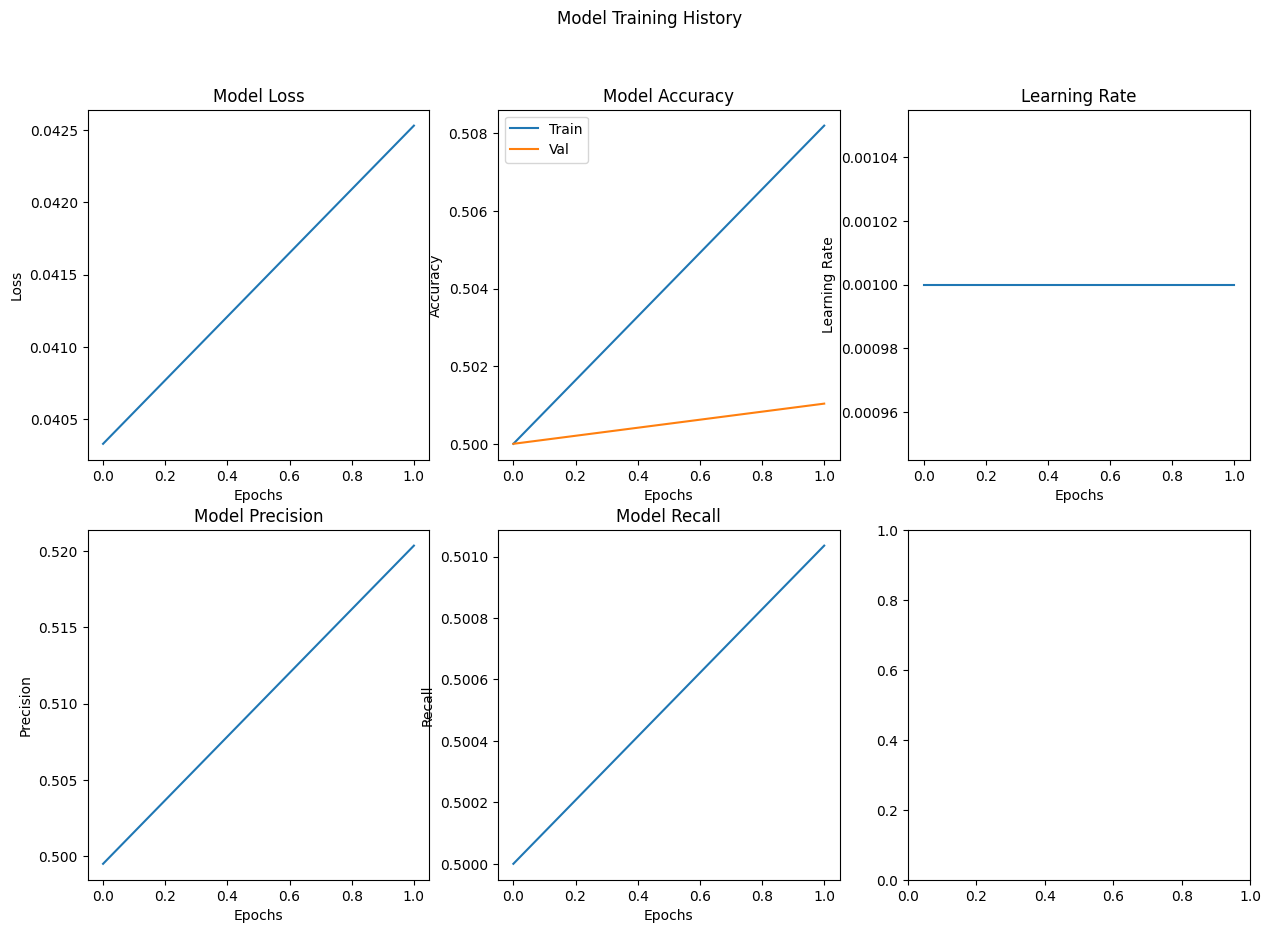

In [71]:
cnn.plot_history()

In [ ]:
cnn.save_model()